In [1]:
!pip install -q kafka-python lightgbm jupyter-dash nest_asyncio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 14.7 MB/s eta 0:00:00


In [2]:
# Here are the dependencies
import numpy as np
import pandas as pd
import threading, queue, time
from lightgbm import LGBMRegressor
from jupyter_dash import JupyterDash
from dash import dcc, html
from dash.dependencies import Output, Input

## Synthetic Real-Time Market Data Generation

In [3]:
# Global variables for simulation
data_queue = queue.Queue(maxsize=1000)  # Here we simulate Kafka topic with a bounded queue
stop_event = threading.Event()          # event to signal threads to stop gracefully

# Let's process synthetic data generator parameters
base_price = 100.0    # starting mid-price
price_volatility = 0.2  # volatility factor for random walk
base_spread = 1.0     # baseline actual quoted spread (could be suboptimal)

In [4]:
def market_data_producer(publish_interval=0.5):
    """Producer thread: generates synthetic market data and puts it into the queue."""
    mid_price = base_price
    tick_count = 0
    last_publish_time = time.time()
    while not stop_event.is_set():
        # Simulate a random walk for mid price
        mid_price += np.random.normal(0, price_volatility)  # random price movement
        if mid_price < 0:
            mid_price = 0  # mid price can't be negative, floor at 0

        # Determine current quote spread (simulate a naive or static quoting strategy)
        current_spread = base_spread
        # (Optional) Add slight random variation to actual spread to mimic changing quotes
        current_spread += np.random.normal(0, 0.1)
        if current_spread < 0.1:
            current_spread = 0.1  # keep spread non-zero

        bid_price = mid_price - current_spread/2
        ask_price = mid_price + current_spread/2

        # Simulate volumes on each side
        vol_bid = np.random.randint(50, 200)
        vol_ask = np.random.randint(50, 200)

        # Timestamp for this quote
        ts = time.time()
        message = {
            'id': tick_count,
            'timestamp': ts,
            'bid': float(bid_price),
            'ask': float(ask_price),
            'vol_bid': int(vol_bid),
            'vol_ask': int(vol_ask)
        }
        try:
            data_queue.put(message, timeout=1)  # publish to "Kafka" queue
        except queue.Full:
            print("Warning: data queue is full, skipping a tick.")

        tick_count += 1

        # Simulate an occasional delay in data feed (for latency alert testing)
        if tick_count % 20 == 0:
            # every 20th tick, sleep longer to simulate a hiccup in data feed
            time.sleep(publish_interval * 3)
        else:
            time.sleep(publish_interval)

## Now, we simulate a Kafka consumer that reads from the data_queue and stores the records in a kdb+-like store

In [5]:
# Initialize the simulated kdb+ table as a Pandas DataFrame
columns = ['timestamp', 'bid', 'ask', 'vol_bid', 'vol_ask', 'mid_price', 'pred_spread', 'true_spread']
quotes_df = pd.DataFrame(columns=columns)
quotes_df.index.name = 'id'  # use the message id as the index for convenience
db_lock = threading.Lock()

In [6]:
def data_consumer():
    """Consumer thread: reads market data from queue and stores it in the DataFrame."""
    while not stop_event.is_set():
        try:
            msg = data_queue.get(timeout=1)
        except queue.Empty:
            if stop_event.is_set():
                break  # exit if stop signal
            continue
        # Compute any additional fields for storage
        mid = (msg['bid'] + msg['ask']) / 2.0
        # Prepare a row entry (pred_spread and true_spread are unknown now, use NaN)
        row = [msg['timestamp'], msg['bid'], msg['ask'], msg['vol_bid'], msg['vol_ask'], mid, np.nan, np.nan]
        # Write to the DataFrame (critical section)
        with db_lock:
            quotes_df.loc[msg['id']] = row
        # Mark the queue task as done
        data_queue.task_done()

## Analytics Microservice, Asynchronous Processing & Model Predictions

In [7]:
model = None

def analytics_service():
    """Analytics thread: reads new data from the DataFrame and computes model predictions."""
    last_mid = None
    current_index = 0  # to keep track of which quote id to process next
    while not stop_event.is_set():
        # Check if there's a new quote to process
        with db_lock:
            max_index = quotes_df.index.max()  # highest ID present
        if pd.isna(max_index):
            # No data yet
            time.sleep(0.1)
            continue
        # Process any new quotes since the last processed index
        while current_index <= max_index and not stop_event.is_set():
            with db_lock:
                if current_index in quotes_df.index:
                    quote = quotes_df.loc[current_index]
                else:
                    break  # no quote with this index (perhaps not arrived yet)
            mid = quote['mid_price']
            # Compute features
            if last_mid is None:
                price_diff = 0.0
            else:
                price_diff = mid - last_mid
            last_mid = mid
            vol_bid = quote['vol_bid']
            vol_ask = quote['vol_ask']
            vol_diff = vol_bid - vol_ask  # imbalance (could also use ratio or abs)

            # Prepare feature vector for the model
            features = np.array([[price_diff, vol_bid, vol_ask, vol_diff]])
            # Predict optimal spread using the trained model
            pred_opt_spread = model.predict(features)[0] if model is not None else np.nan

            # Compute true optimal spread using our known formula (for evaluation)
            true_opt_spread = true_spread_formula(price_diff, vol_bid, vol_ask)

            # Store the predictions in the DataFrame
            with db_lock:
                quotes_df.at[current_index, 'pred_spread'] = float(pred_opt_spread)
                quotes_df.at[current_index, 'true_spread'] = float(true_opt_spread)
            # (In a real system, we might also publish pred_opt_spread to another Kafka topic or send to the quoting engine)
            current_index += 1
        # Small sleep to avoid tight loop
        time.sleep(0.1)

## Modeling: Training the LightGBM Model for Optimal Spread

In [9]:
# For simulation, let's define a hypothetical formula for optimal spread
def true_spread_formula(price_diff, vol_bid, vol_ask):
    return 0.5 + 0.2 * abs(price_diff) + 0.005 * abs(vol_bid - vol_ask)

## We will simulate, say, 10,000 data points for training

In [10]:
# Generate synthetic training data
np.random.seed(42)
train_size = 10000

price_diffs = np.random.normal(0, 0.5, size=train_size)  # Here, we simulate price changes
vol_bids = np.random.randint(50, 200, size=train_size)
vol_asks = np.random.randint(50, 200, size=train_size)
vol_diffs = vol_bids - vol_asks

# Let's compute true optimal spread using the formula for each sample
true_spreads = [true_spread_formula(pd, vb, va) for pd, vb, va in zip(price_diffs, vol_bids, vol_asks)]

# Prepare feature matrix X and target vector y
X_train = np.column_stack([price_diffs, vol_bids, vol_asks, vol_diffs])
y_train = np.array(true_spreads)

## Train LightGBM Regressor

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Split data into training and testing sets
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize and train the LightGBM model
model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='l1')

# Evaluate the model on the validation set
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Validation MAE: {mae:.3f}, R^2: {r2:.3f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 812
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 4
[LightGBM] [Info] Start training from score 0.827258
Validation MAE: 0.004, R^2: 0.999


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Deployment: Launching the Real-Time Pipeline and Dashboard

In [20]:
# Start Background Services (Kafka & Microservices Simulation)
# Start the producer, consumer, and analytics threads
producer_thread = threading.Thread(target=market_data_producer, args=(0.5,), daemon=True)
consumer_thread = threading.Thread(target=data_consumer, daemon=True)
analytics_thread = threading.Thread(target=analytics_service, daemon=True)

producer_thread.start()
consumer_thread.start()
analytics_thread.start()

# Give threads a moment to start and produce initial data
time.sleep(1.0)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

## Dashboard Layout

In [14]:
# Initialize JupyterDash app
app = JupyterDash(__name__)

app.layout = html.Div([
    html.H2("Market Making Simulation Dashboard"),
    html.Div(id='alert-div', children="Initializing data...", style={'color': 'orange', 'font-weight': 'bold'}),
    dcc.Graph(id='price-graph'),
    dcc.Graph(id='spread-graph'),
    dcc.Interval(id='interval-component', interval=1000, n_intervals=0)  # update every 1 second
])

/usr/local/lib/python3.11/dist-packages/dash/dash.py:587: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



## Callback Implementation

In [18]:
@app.callback(
    [Output('price-graph', 'figure'),
     Output('spread-graph', 'figure'),
     Output('alert-div', 'children'),
     Output('alert-div', 'style')],
    [Input('interval-component', 'n_intervals')]
)
def update_dashboard(n):
    # Fetch a copy of the latest data (to avoid long lock holding)
    with db_lock:
        df_copy = quotes_df.copy()
    if df_copy.empty:
        # If no data yet, show initial message
        return {}, {}, "Waiting for data...", {'color': 'orange', 'font-weight': 'bold'}

    # Prepare time axis (convert timestamps to a relative or readable format)
    # We'll use relative tick index as x for simplicity
    df_copy = df_copy.sort_index()  # ensure sorted by id (time order)
    x = df_copy.index  # using the id as the x-axis (which increments with each tick)

    # Price chart data
    bid_prices = df_copy['bid']
    ask_prices = df_copy['ask']
    price_fig = {
        'data': [
            {'x': x, 'y': bid_prices, 'type': 'line', 'name': 'Bid Price'},
            {'x': x, 'y': ask_prices, 'type': 'line', 'name': 'Ask Price'}
        ],
        'layout': {
            'title': 'Bid/Ask Prices Over Time',
            'xaxis': {'title': 'Quote Index'},
            'yaxis': {'title': 'Price'}
        }
    }

    # Spread chart data (only include points where prediction exists)
    pred_series = df_copy['pred_spread']
    true_series = df_copy['true_spread']
    # Drop NaN values (unprocessed points) to avoid gaps
    valid_idx = ~pd.isna(pred_series)
    spread_fig = {
        'data': [
            {'x': x[valid_idx], 'y': pred_series[valid_idx], 'type': 'line', 'name': 'Predicted Optimal Spread'},
            {'x': x[valid_idx], 'y': true_series[valid_idx], 'type': 'line', 'name': 'True Optimal Spread', 'line': {'dash': 'dash'}}
        ],
        'layout': {
            'title': 'Optimal Spread: Predicted vs True',
            'xaxis': {'title': 'Quote Index'},
            'yaxis': {'title': 'Spread Width'}
        }
    }

    # Alert logic
    alert_text = ""
    alert_style = {'color': 'green', 'font-weight': 'bold'}
    # Latency check: time since last data point
    last_ts = df_copy['timestamp'].iloc[-1]
    now = time.time()
    if now - last_ts > 1.0:  # if last data is more than 1s old (assuming ~0.5s publish, this indicates a lag)
        alert_text += "Latency Alert: Data feed is delayed! "
        alert_style['color'] = 'red'
    # Quote quality check: compare last pred vs true optimal
    if not pd.isna(df_copy['pred_spread'].iloc[-1]) and not pd.isna(df_copy['true_spread'].iloc[-1]):
        pred_last = df_copy['pred_spread'].iloc[-1]
        true_last = df_copy['true_spread'].iloc[-1]
        if abs(pred_last - true_last) > 0.2:
            alert_text += "Quote Quality Alert: Model vs true spread deviation high!"
            alert_style['color'] = 'red'
    # If no alerts
    if alert_text == "":
        alert_text = "All systems normal."
        alert_style['color'] = 'green'

    return price_fig, spread_fig, alert_text, alert_style

## With the callback in place, we can run the Dash app

In [23]:
with db_lock:
    print("rows in quotes_df →", len(quotes_df))
    display(quotes_df.tail(3))


rows in quotes_df → 1822


,timestamp,bid,ask,vol_bid,vol_ask,mid_price,pred_spread,true_spread
id,,,,,,,,
1819,1.746823e+09,97.488980,98.531828,135.0,92.0,98.010404,0.750312,0.747746
1820,1.746823e+09,97.370799,98.420456,110.0,56.0,97.895628,0.794936,0.792955
1821,1.746823e+09,97.120704,98.144502,81.0,128.0,97.632603,0.786243,0.787605


In [25]:
# produce a single dummy row to make sure the graph plots
with db_lock:
    quotes_df.loc[0] = [time.time(), 99.5, 100.5, 120, 130, 100.0, 1.0, 1.0]


In [26]:
stop_event.set()     # stop old threads if any
time.sleep(0.5)

stop_event.clear()
quotes_df.drop(quotes_df.index, inplace=True)   # empty the table

producer_thread = threading.Thread(target=market_data_producer, args=(0.5,), daemon=True)
consumer_thread = threading.Thread(target=data_consumer, daemon=True)
analytics_thread = threading.Thread(target=analytics_service, daemon=True)

producer_thread.start()
consumer_thread.start()
analytics_thread.start()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [30]:
stop_event.set(); time.sleep(0.2); stop_event.clear()
producer_thread = threading.Thread(target=market_data_producer, args=(0.5,), daemon=True); producer_thread.start()
consumer_thread = threading.Thread(target=data_consumer, daemon=True); consumer_thread.start()
analytics_thread = threading.Thread(target=analytics_service, daemon=True); analytics_thread.start()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [31]:
print(model)          # should print LGBMRegressor(...)


LGBMRegressor(random_state=42)


In [33]:
with db_lock:
    df_copy = quotes_df.copy()

pred_series = df_copy['pred_spread']     # now the name exists
valid_idx   = ~pd.isna(pred_series)      # boolean mask with no error


In [34]:
def update_dashboard(n):
    with db_lock:
        df_copy = quotes_df.copy()

    pred_series = df_copy['pred_spread']
    valid_idx   = ~pd.isna(pred_series)   #
    ...


In [37]:
import pandas as pd

# Thread-safe extraction of data
with db_lock:
    df = quotes_df.copy()  # Copy shared DataFrame under lock:contentReference[oaicite:1]{index=1}

# Filter out rows with missing critical values
df_prices = df.dropna(subset=['bid', 'ask'])
df_spreads = df.dropna(subset=['pred_spread', 'true_spread'])

# If timestamp exists and we want to use it as x-axis:
# Ensure timestamp is in datetime format (if not already)
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# x_vals = df['timestamp']
# Otherwise, use index as a time proxy:
x_vals_prices = df_prices.index
x_vals_spreads = df_spreads.index


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 812
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 4
[LightGBM] [Info] Start training from score 0.831096
Threads started.  Wait a few seconds…


Exception in thread Thread-86 (analytics_service):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'mid_price'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-7-3655ff

rows = 20   with predictions = 10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



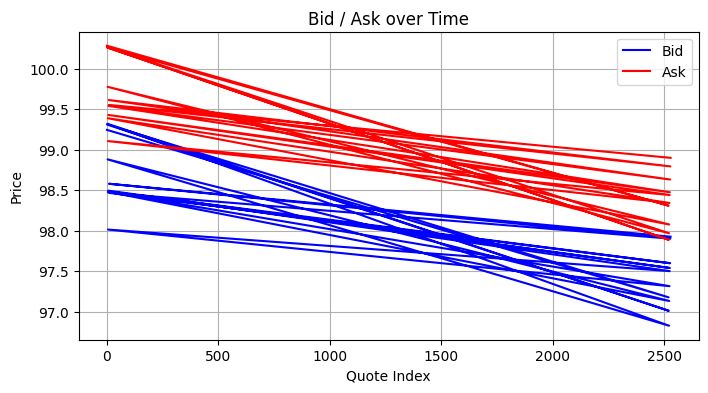

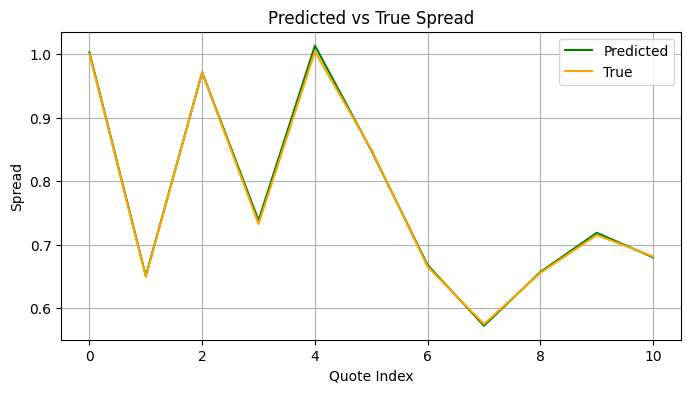

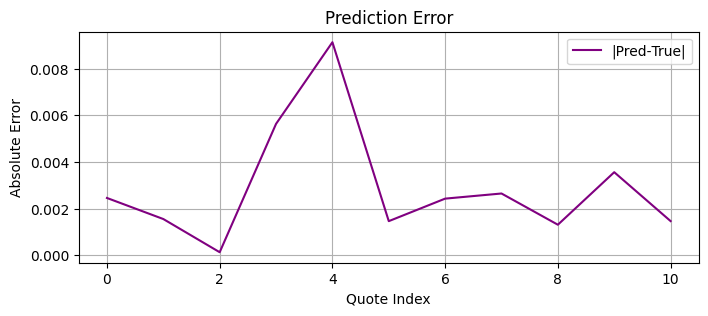

In [41]:
# We first install dependencies
!pip install -q lightgbm

# Let's import dependencies
import numpy as np, pandas as pd, time, threading, queue
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

# Shared state ----------------------------------------------------------------
quotes_df  = pd.DataFrame(columns=['timestamp','bid','ask','vol_bid','vol_ask',
                                   'mid','pred_spread','true_spread'])
quotes_df.index.name = 'id'

db_lock    = threading.Lock()          # guard the DataFrame
data_queue = queue.Queue(maxsize=500)  # Here we simulates a Kafka topic
stop_event = threading.Event()         # graceful shutdown flag

# Synthetic‑feed parameters
BASE_PRICE      = 100.0
PRICE_VOL       = 0.20     # random‑walk σ
BASE_SPREAD     = 1.0
TICK_INTERVAL_S = 0.50

#  TRUE‑SPREAD FORMULA  (ground‑truth for training / scoring)

def true_spread(price_diff: float, vol_bid: int, vol_ask: int) -> float:
    """Toy analytic formula for the 'optimal' quoted spread."""
    return 0.5 + 0.2 * abs(price_diff) + 0.005 * abs(vol_bid - vol_ask)

# SYNTHETIC TRAINING SET  & MODEL FIT

def train_model(n_samples: int = 10_000) -> LGBMRegressor:
    rng = np.random.default_rng(42)
    price_diffs = rng.normal(0, 0.5, n_samples)
    vol_bids    = rng.integers(50, 200, n_samples)
    vol_asks    = rng.integers(50, 200, n_samples)
    vol_diffs   = vol_bids - vol_asks
    y           = [true_spread(d, vb, va)
                   for d, vb, va in zip(price_diffs, vol_bids, vol_asks)]
    X = np.column_stack([price_diffs, vol_bids, vol_asks, vol_diffs])

    model = LGBMRegressor(n_estimators=120, learning_rate=0.1, random_state=1)
    model.fit(X, y)
    return model

model = train_model()      # fit once before threads start

# 4.  THREADS: PRODUCER, CONSUMER, ANALYTICS

def market_data_producer():
    """Generate synthetic quote ticks and publish to queue."""
    rng = np.random.default_rng()
    mid = BASE_PRICE
    tick_id = 0
    while not stop_event.is_set():
        mid += rng.normal(0, PRICE_VOL)
        curr_spread = max(BASE_SPREAD + rng.normal(0, 0.1), 0.1)
        bid, ask = mid - curr_spread/2, mid + curr_spread/2
        vb, va   = rng.integers(50, 200), rng.integers(50, 200)

        msg = dict(id=tick_id, timestamp=time.time(),
                   bid=float(bid), ask=float(ask),
                   vol_bid=int(vb), vol_ask=int(va))
        try:
            data_queue.put_nowait(msg)
        except queue.Full:
            pass   # drop tick on overflow (or log warning)
        tick_id += 1

        # deliberate hiccup every 20 ticks (latency test)
        time.sleep(TICK_INTERVAL_S * (3 if tick_id % 20 == 0 else 1))

def data_consumer():
    """Read queue and append rows to quotes_df."""
    while not stop_event.is_set():
        try:
            msg = data_queue.get(timeout=0.5)
        except queue.Empty:
            continue
        mid = (msg['bid'] + msg['ask']) / 2
        row = [msg['timestamp'], msg['bid'], msg['ask'],
               msg['vol_bid'], msg['vol_ask'], mid, np.nan, np.nan]
        with db_lock:
            quotes_df.loc[msg['id']] = row
        data_queue.task_done()

def analytics_service():
    """Compute features, predict optimal spread, write back."""
    last_mid = None
    next_idx = 0
    while not stop_event.is_set():
        with db_lock:
            if next_idx not in quotes_df.index:
                # no fresh quote yet
                pass
            else:
                quote = quotes_df.loc[next_idx]
                mid   = quote['mid']
                price_diff = 0.0 if last_mid is None else mid - last_mid
                last_mid   = mid

                vb, va   = quote['vol_bid'], quote['vol_ask']
                X        = np.array([[price_diff, vb, va, vb - va]])
                pred_sp  = model.predict(X)[0]
                true_sp  = true_spread(price_diff, vb, va)

                quotes_df.at[next_idx, 'pred_spread'] = float(pred_sp)
                quotes_df.at[next_idx, 'true_spread'] = float(true_sp)
                next_idx += 1
        time.sleep(0.01)

# 5.  PIPELINE CONTROL HELPERS

def start_pipeline():
    """Launch producer / consumer / analytics threads."""
    stop_event.clear()
    global producer_t, consumer_t, analytics_t
    producer_t  = threading.Thread(target=market_data_producer, daemon=True)
    consumer_t  = threading.Thread(target=data_consumer, daemon=True)
    analytics_t = threading.Thread(target=analytics_service, daemon=True)
    producer_t.start(); consumer_t.start(); analytics_t.start()

def stop_pipeline():
    stop_event.set()
    for t in (producer_t, consumer_t, analytics_t):
        t.join(timeout=1)

# 6.  (RE)START  &  INSPECTION CELL

start_pipeline()
print("Threads started.  Wait a few seconds…")
time.sleep(5)      # let it accumulate some ticks

# Quick sanity check
with db_lock:
    print("rows =", len(quotes_df),
          "  with predictions =", quotes_df['pred_spread'].notna().sum())

#  STATIC MATPLOTLIB VISUALS

def plot_prices():
    with db_lock:
        df = quotes_df.dropna(subset=['bid','ask']).copy()
    if df.empty:
        print("No price data yet."); return
    plt.figure(figsize=(8,4))
    plt.plot(df.index, df['bid'], label='Bid', c='blue')
    plt.plot(df.index, df['ask'], label='Ask', c='red')
    plt.xlabel('Quote Index'); plt.ylabel('Price')
    plt.title('Bid / Ask over Time'); plt.legend(); plt.grid(True); plt.show()

def plot_spreads():
    with db_lock:
        df = quotes_df.dropna(subset=['pred_spread','true_spread']).copy()
    if df.empty:
        print("No spread data yet."); return
    plt.figure(figsize=(8,4))
    plt.plot(df.index, df['pred_spread'], label='Predicted', c='green')
    plt.plot(df.index, df['true_spread'], label='True', c='orange')
    plt.xlabel('Quote Index'); plt.ylabel('Spread')
    plt.title('Predicted vs True Spread'); plt.legend(); plt.grid(True); plt.show()

def plot_error():
    with db_lock:
        df = quotes_df.dropna(subset=['pred_spread','true_spread']).copy()
    if df.empty:
        print("No error data yet."); return
    err = (df['pred_spread'] - df['true_spread']).abs()
    plt.figure(figsize=(8,3))
    plt.plot(df.index, err, c='purple', label='|Pred‑True|')
    plt.xlabel('Quote Index'); plt.ylabel('Absolute Error')
    plt.title('Prediction Error'); plt.legend(); plt.grid(True); plt.show()

# Call plotting helpers whenever you want a snapshot:
plot_prices()
plot_spreads()
plot_error()

# Here's a debugging step, I commented it: CLEAN SHUTDOWN (run at the end of your session)

# stop_pipeline()